In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sam.segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor


In [6]:
checkpoint = "checkpoints/sam_vit_b_01ec64.pth"
model_type = "vit_b"
sam = sam_model_registry[model_type](checkpoint=checkpoint)
print(f"Модель {model_type} загружена из {checkpoint}")

Модель vit_b загружена из checkpoints/sam_vit_b_01ec64.pth


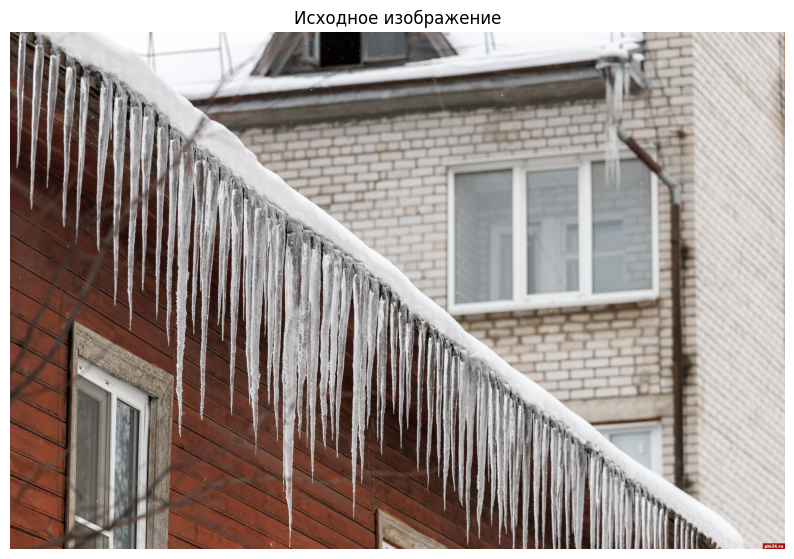

In [9]:
image_path = "test1.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.title("Исходное изображение")
plt.show()

In [10]:
mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side=32,
    pred_iou_thresh=0.80,
    stability_score_thresh=0.90,
    min_mask_region_area=100 
)

masks = mask_generator.generate(image)

print(f"Найдено {len(masks)} объектов")

Найдено 40 объектов


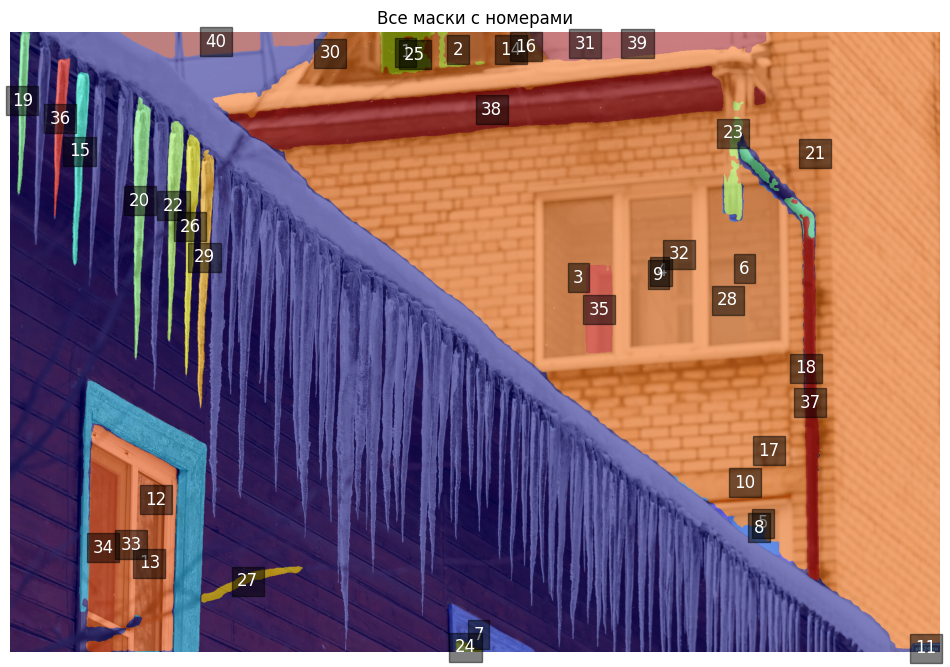

In [11]:
combined_mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)
plt.figure(figsize=(12, 12))
plt.imshow(image)

for i, mask_data in enumerate(masks):
    mask = mask_data['segmentation']
    combined_mask[mask] = i + 1 
    y, x = np.where(mask)
    if len(x) > 0 and len(y) > 0:
        center_x, center_y = int(np.mean(x)), int(np.mean(y))
        plt.text(center_x, center_y, str(i + 1), color='white', fontsize=12, 
                 ha='center', va='center', bbox=dict(facecolor='black', alpha=0.5))

plt.imshow(combined_mask, alpha=0.5, cmap='jet')
plt.axis('off')
plt.title("Все маски с номерами")
plt.show()

In [7]:
predictor = SamPredictor(sam)

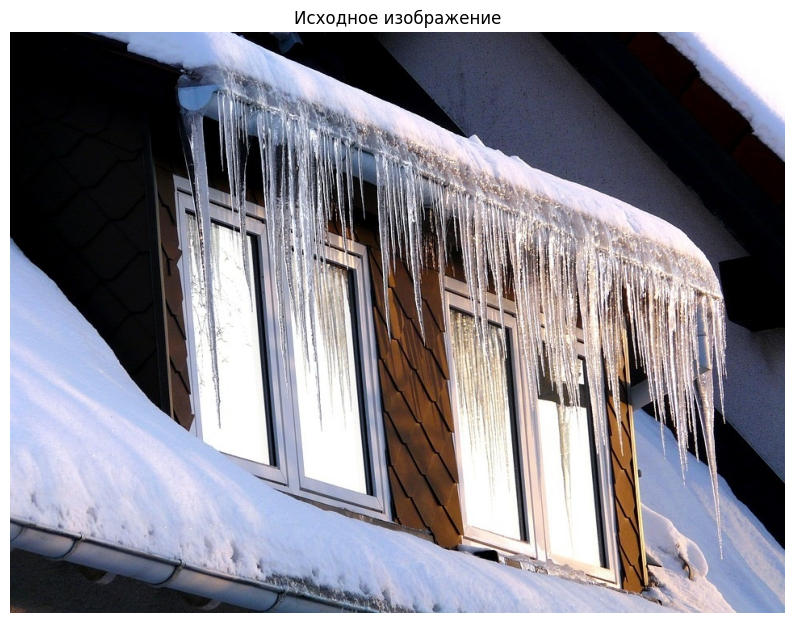

In [13]:
image_path = "test2.jpg" 
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.title("Исходное изображение")
plt.show()

In [ ]:
points = []
labels = []

def mouse_callback(event, x, y, flags, param):
    global points, labels
    if event == cv2.EVENT_LBUTTONDOWN: 
        points.append([x, y])
        labels.append(1)  
        cv2.circle(image_display, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow("Выбери точки", image_display)
    elif event == cv2.EVENT_RBUTTONDOWN: 
        points.append([x, y])
        labels.append(0)  
        cv2.circle(image_display, (x, y), 5, (0, 0, 255), -1)
        cv2.imshow("Выбери точки", image_display)

image_display = cv2.cvtColor(image, cv2.COLOR_RGB2BGR).copy()
cv2.imshow("Выбери точки", image_display)
cv2.setMouseCallback("Выбери точки", mouse_callback)

while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

input_point = np.array(points)
input_label = np.array(labels)

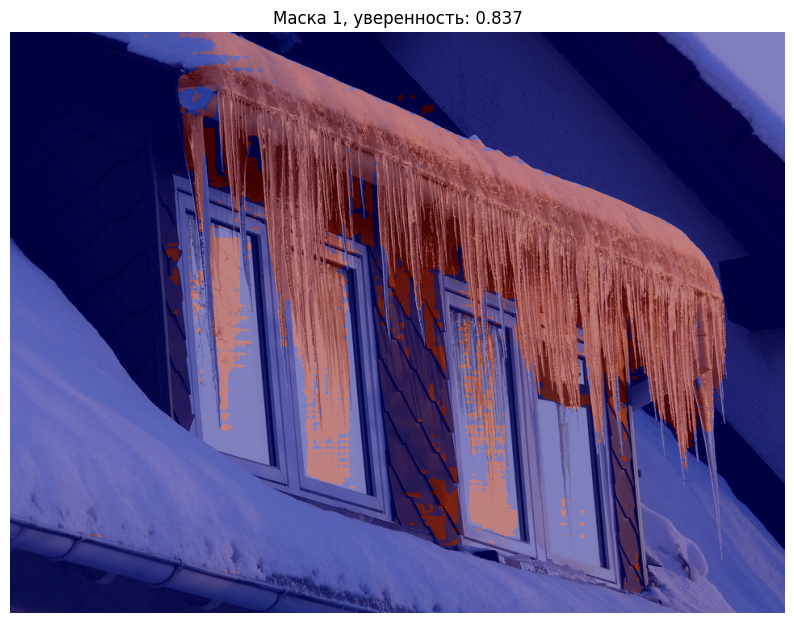

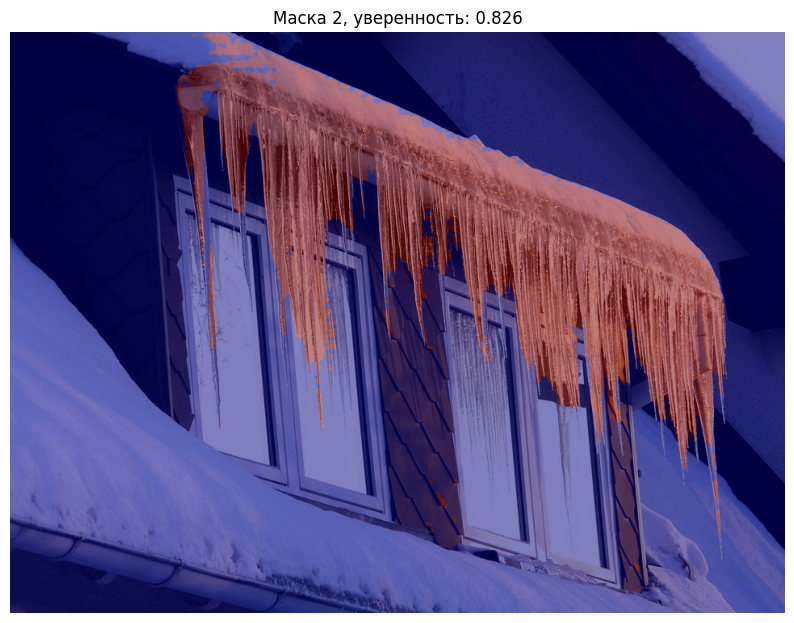

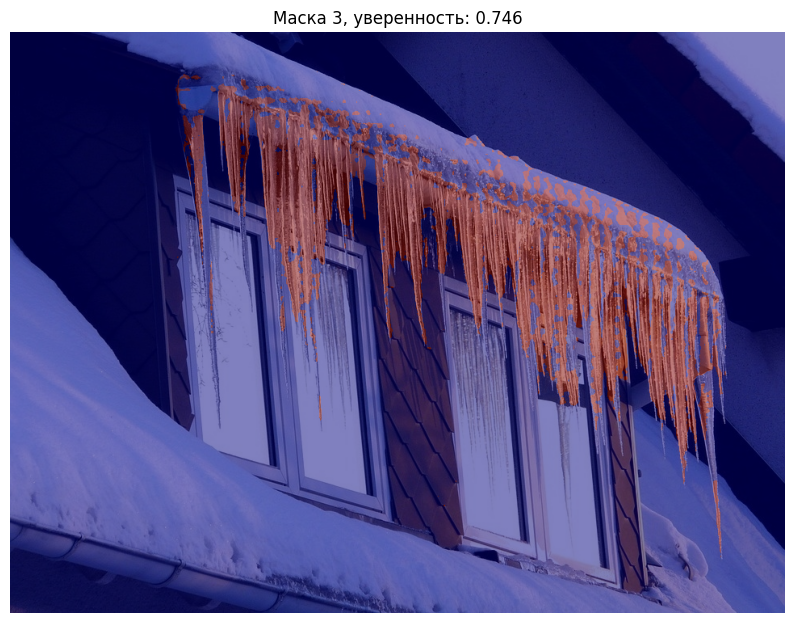

In [15]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True 
)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5, cmap='jet')
    plt.title(f"Маска {i+1}, уверенность: {score:.3f}")
    plt.axis('off')
    plt.show()

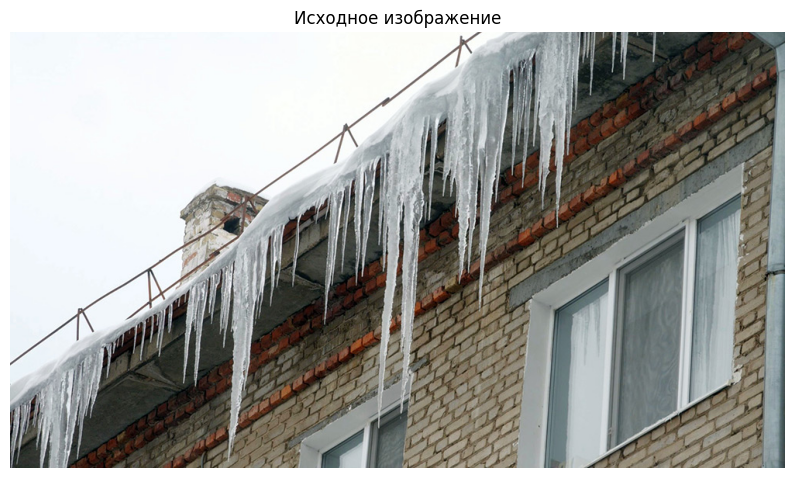

In [8]:
image_path = "test3.jpg" 
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.title("Исходное изображение")
plt.show()

In [ ]:
boxes = []
start_point = None
end_point = None
drawing = False

def draw_box(event, x, y, flags, param):
    global start_point, end_point, drawing
    if event == cv2.EVENT_LBUTTONDOWN: 
        drawing = True
        start_point = [x, y]
    elif event == cv2.EVENT_MOUSEMOVE and drawing:
        img_copy = image_display.copy()
        for box in boxes:
            cv2.rectangle(img_copy, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
        cv2.rectangle(img_copy, tuple(start_point), (x, y), (0, 255, 0), 2)
        cv2.imshow("Нарисуй рамки", img_copy)
    elif event == cv2.EVENT_LBUTTONUP: 
        drawing = False
        end_point = [x, y]
        boxes.append([start_point[0], start_point[1], end_point[0], end_point[1]])
        cv2.rectangle(image_display, tuple(start_point), tuple(end_point), (0, 255, 0), 2)
        cv2.imshow("Нарисуй рамки", image_display)

image_display = cv2.cvtColor(image, cv2.COLOR_RGB2BGR).copy()
cv2.imshow("Нарисуй рамки", image_display)
cv2.setMouseCallback("Нарисуй рамки", draw_box)

while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

if boxes:
    boxes_array = np.array(boxes)
else:
    boxes_array = None

In [ ]:
if boxes_array is not None:
    all_masks = []
    all_scores = []
    for i, box in enumerate(boxes_array):
        masks, scores, logits = predictor.predict(
            box=box,
            multimask_output=True
        )
        best_mask_idx = np.argmax(scores)
        all_masks.append(masks[best_mask_idx])
        all_scores.append(scores[best_mask_idx])
    
    plt.figure(figsize=(12, 12))
    plt.imshow(image)
    for i, mask in enumerate(all_masks):
        plt.imshow(mask, alpha=0.5, cmap='jet', label=f"Рамка {i+1}")
        y, x = np.where(mask)
        if len(x) > 0 and len(y) > 0:
            center_x, center_y = int(np.mean(x)), int(np.mean(y))
            plt.text(center_x, center_y, str(i+1), color='white', fontsize=12, 
                     ha='center', va='center', bbox=dict(facecolor='black', alpha=0.5))
    plt.axis('off')
    plt.title("Маски для всех рамок")
    plt.show()